# Détection de SPAM SMS avec Deep Learning – Projet AT&T

## 1. Introduction & Contexte

### Contexte business

AT&T Inc. est une multinationale américaine de télécommunications, leader mondial par les revenus.  
Un problème récurrent pour ses clients : la **réception constante de SMS indésirables (SPAM)**.

Ces messages peuvent :
- nuire à l’expérience utilisateur,
- masquer des messages importants,
- être utilisés pour des tentatives de phishing ou d’arnaque.

AT&T souhaite donc mettre en place un **système automatique de détection de SPAM** sur les SMS entrants.

### Problème à résoudre

Construire un modèle de Machine Learning / Deep Learning capable de classifier un SMS comme :

- **ham** : message normal / légitime,
- **spam** : message indésirable.

Objectif : **filtrer au maximum les SPAM** sans bloquer les messages légitimes.

### Dataset utilisé

Nous utilisons le dataset public suivant :  

`https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv`

Ce dataset contient :
- un texte de SMS,
- un label : `ham` ou `spam`.

### Objectifs techniques du projet

1. **Préprocessing du texte** (nettoyage, normalisation).
2. Construction d’un **premier modèle Deep Learning simple** (embedding + LSTM ou GRU).
3. Mise en place d’un modèle **plus avancé via Transfer Learning** (ex : DistilBERT).
4. **Comparaison des performances** des deux approches.
5. Interprétation des résultats et **recommandations pour AT&T**.

---

In [1]:
# 2. Import des librairies & configuration globale

import warnings
warnings.filterwarnings("ignore")

import os
import re
import string
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score
)

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models

# Pour BERT / DistilBERT
try:
    import torch
    from torch.utils.data import Dataset
    from transformers import (
        AutoTokenizer,
        AutoModelForSequenceClassification,
        TrainingArguments,
        Trainer,
        EarlyStoppingCallback
    )
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False

# Style graphiques
sns.set(style="whitegrid")

# Fixer les seeds pour la reproductibilité
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)


# Reproductibilité PyTorch (Transformers)

if TRANSFORMERS_AVAILABLE:
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    

# Détection GPU

print("TensorFlow version:", tf.__version__)
print("GPU disponible TF ?", len(tf.config.list_physical_devices('GPU')) > 0)

if TRANSFORMERS_AVAILABLE:
    print("PyTorch version:", torch.__version__)
    print("GPU disponible Torch ?", torch.cuda.is_available())
else:
    print("Transformers non installé, la partie BERT devra être adaptée (pip install transformers).")


TensorFlow version: 2.14.0
GPU disponible TF ? False
PyTorch version: 2.8.0+cpu
GPU disponible Torch ? False


### Chargement du dataset

On charge directement le CSV depuis l’URL fournie.  
Les noms de colonnes peuvent légèrement varier (par exemple : `label` / `Category`, `text` / `Message`).  
On gère donc cette variation de manière robuste.

In [2]:
# 2.1 Chargement du dataset

DATA_URL = "https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv"

# Lecture robuste avec fallback ISO-8859-1
try:
    df = pd.read_csv(DATA_URL, encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

print("Aperçu brut du dataset :")
display(df.head())
print("\nColonnes :", df.columns.tolist())
print("Shape :", df.shape)

# Standardisation simple des noms de colonnes
df.columns = [c.lower() for c in df.columns]

# Renommage propre des colonnes connues (v1, v2)
rename_map = {
    "v1": "label",
    "v2": "text"
}
df = df.rename(columns=rename_map)

# Garde uniquement ces colonnes si elles existent
cols_keep = [c for c in ["label", "text"] if c in df.columns]
df = df[cols_keep]

# Vérifications
label_col = "label"
text_col = "text"

print(f"\nColonne label utilisée : {label_col}")
print(f"Colonne texte utilisée : {text_col}")

display(df.head())
print("Shape final :", df.shape)

Aperçu brut du dataset :


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



Colonnes : ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
Shape : (5572, 5)

Colonne label utilisée : label
Colonne texte utilisée : text


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Shape final : (5572, 2)


## 3. EDA rapide & Nettoyage

Objectifs de cette section :

- Vérifier la qualité du dataset  
- Visualiser la distribution ham / spam  
- Nettoyer les doublons  
- Préparer le texte pour le Deep Learning  

L’idée est d’aller **à l’essentiel** pour comprendre les données avant modélisation.

In [3]:
print("Shape :", df.shape)
print("\nValeurs manquantes :")
print(df.isna().sum())

Shape : (5572, 2)

Valeurs manquantes :
label    0
text     0
dtype: int64


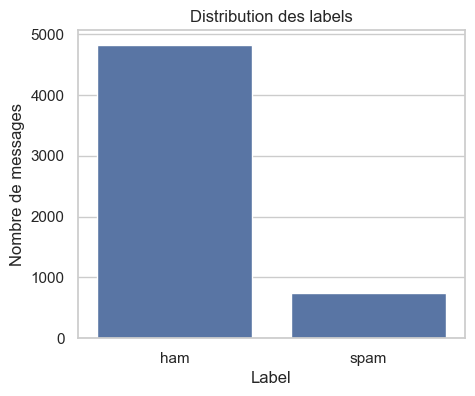

In [4]:
label_counts = df[label_col].value_counts()

plt.figure(figsize=(5,4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribution des labels")
plt.xlabel("Label")
plt.ylabel("Nombre de messages")
plt.show()

In [5]:
before = df.shape[0]
df = df.drop_duplicates(subset=[label_col, text_col])
after = df.shape[0]

print(f"Doublons supprimés : {before - after}")
print("Shape final :", df.shape)

Doublons supprimés : 403
Shape final : (5169, 2)


### Nettoyage des SMS

Nous appliquons un nettoyage simple mais efficace :

- Mise en minuscule  
- Suppression de la ponctuation  
- Suppression des chiffres  
- Suppression des espaces multiples  

Cela facilite la tokenization du modèle baseline.

In [6]:
def clean_text_lstm(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"\d+", " <NUM> ", text)   
    text = re.sub(r"[^\w\s]", " ", text)     
    text = re.sub(r"\s+", " ", text).strip()
    return text

def clean_text_bert(text):
    if not isinstance(text, str):
        return ""
    return text.strip()  

df["text_lstm"] = df[text_col].apply(clean_text_lstm)
df["text_bert"] = df[text_col].apply(clean_text_bert)

display(df[[text_col, "text_lstm", "text_bert"]].head())


,text,text_lstm,text_bert
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,"Go until jurong point, crazy.. Available only ..."
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni,Ok lar... Joking wif u oni...
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in NUM a wkly comp to win fa cup fi...,Free entry in 2 a wkly comp to win FA Cup fina...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,U dun say so early hor... U c already then say...
4,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
def clean_text_lstm(text):
    text = text.lower()
    text = re.sub(r"\d+", " <NUM> ", text)      # garder l'info chiffre
    text = re.sub(r"[^\w\s]", " ", text)        # ponctuation supprimée
    text = re.sub(r"\s+", " ", text).strip()
    return text

def clean_text_bert(text):
    return text.strip()  # nettoyage minimal pour BERT

df["text_lstm"] = df["text"].apply(clean_text_lstm)
df["text_bert"] = df["text"].apply(clean_text_bert)

df[["text", "text_lstm", "text_bert"]].head()

,text,text_lstm,text_bert
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,"Go until jurong point, crazy.. Available only ..."
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni,Ok lar... Joking wif u oni...
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in NUM a wkly comp to win fa cup fi...,Free entry in 2 a wkly comp to win FA Cup fina...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,U dun say so early hor... U c already then say...
4,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...,"Nah I don't think he goes to usf, he lives aro..."


## 4. Préprocessing NLP

Dans cette partie :

1. Encodage du label en 0/1  
2. Découpage train/test  
3. Tokenization & Padding pour le modèle LSTM  

In [8]:
label_mapping = {"ham": 0, "spam": 1}
df["label_encoded"] = df[label_col].map(label_mapping)

print(df["label_encoded"].value_counts())

label_encoded
0    4516
1     653
Name: count, dtype: int64


In [9]:
X = df["text_lstm"].values
y = df["label_encoded"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(len(X_train), len(X_test))

4135 1034


In [10]:
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 64

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post")

print(X_train_pad.shape, X_test_pad.shape)

(4135, 100) (1034, 100)


## 5. Modèle Baseline – Embedding + LSTM

Nous construisons un modèle Deep Learning simple :

- Embedding Layer  
- LSTM bidirectionnel  
- Denses  
- Activation sigmoid  
- Metrics : Accuracy + AUC  

Ce modèle sert de **baseline** avant le Transfer Learning.

In [11]:
vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)

baseline_model = models.Sequential([
    layers.Input(shape=(MAX_SEQUENCE_LENGTH,)),                    
    layers.Embedding(
        input_dim=vocab_size,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_SEQUENCE_LENGTH
    ),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

baseline_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           436096    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [12]:
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_auc", mode="max", patience=2, restore_best_weights=True
)

history_baseline = baseline_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=[early]
)

Epoch 1/10
52/52 [==============================] - 12s 166ms/step - loss: 0.3305 - accuracy: 0.8827 - auc: 0.7886 - val_loss: 0.0675 - val_accuracy: 0.9831 - val_auc: 0.9911
Epoch 2/10
52/52 [==============================] - 7s 132ms/step - loss: 0.0598 - accuracy: 0.9837 - auc: 0.9916 - val_loss: 0.0460 - val_accuracy: 0.9879 - val_auc: 0.9879
Epoch 3/10
52/52 [==============================] - 7s 128ms/step - loss: 0.0246 - accuracy: 0.9930 - auc: 0.9960 - val_loss: 0.0551 - val_accuracy: 0.9831 - val_auc: 0.9920
Epoch 4/10
52/52 [==============================] - 7s 135ms/step - loss: 0.0055 - accuracy: 0.9985 - auc: 1.0000 - val_loss: 0.0492 - val_accuracy: 0.9915 - val_auc: 0.9838
Epoch 5/10
52/52 [==============================] - 7s 126ms/step - loss: 0.0013 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0594 - val_accuracy: 0.9903 - val_auc: 0.9833


In [13]:
loss, acc, auc = baseline_model.evaluate(X_test_pad, y_test)
print(f"Loss: {loss:.4f} — Acc: {acc:.4f} — AUC: {auc:.4f}")

33/33 [==============================] - 1s 24ms/step - loss: 0.0640 - accuracy: 0.9845 - auc: 0.9851
Loss: 0.0640 — Acc: 0.9845 — AUC: 0.9851


33/33 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       903
           1       0.95      0.92      0.94       131

    accuracy                           0.98      1034
   macro avg       0.97      0.96      0.96      1034
weighted avg       0.98      0.98      0.98      1034



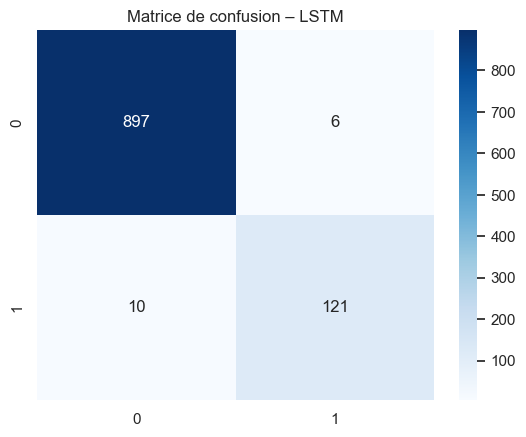

In [14]:
y_proba = baseline_model.predict(X_test_pad).ravel()
y_pred = (y_proba >= 0.5).astype(int)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion – LSTM")
plt.show()

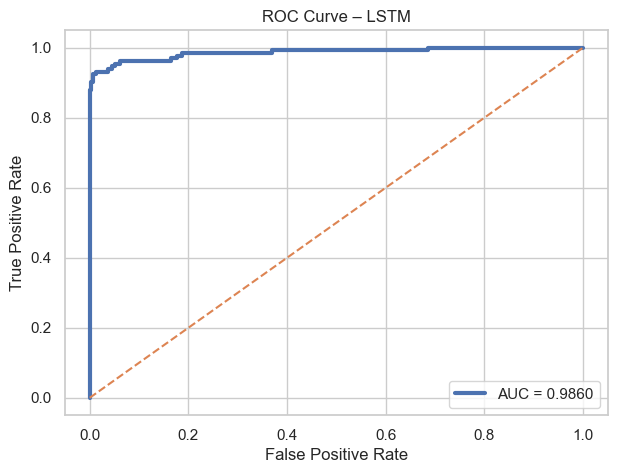

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', linewidth=3)
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve – LSTM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.show()

## 6. Transfer Learning – DistilBERT

Nous utilisons maintenant un modèle pré-entraîné : **DistilBERT**.

Avantages :

- Compréhension profonde du langage  
- Meilleure généralisation  
- Meilleur rappel SPAM  

Nous réalisons un fine-tuning du modèle sur notre dataset.

In [16]:
if not TRANSFORMERS_AVAILABLE:
    raise ImportError("Install Transformers : pip install transformers datasets accelerate")

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [17]:
MODEL_NAME = "distilbert-base-uncased"

tokenizer_bert = AutoTokenizer.from_pretrained(MODEL_NAME)
model_bert = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
texts = df["text_bert"].tolist()
labels = df["label_encoded"].tolist()

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    texts, labels, test_size=0.2, random_state=SEED, stratify=labels
)

X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(
    X_train_b, y_train_b, test_size=0.1, random_state=SEED
)

In [19]:
class SmsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(self.labels[idx])
        }

train_dataset = SmsDataset(X_train_b, y_train_b, tokenizer_bert)
val_dataset   = SmsDataset(X_val_b, y_val_b, tokenizer_bert)
test_dataset  = SmsDataset(X_test_b, y_test_b, tokenizer_bert)

In [20]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
    preds = np.argmax(probs, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "auc": roc_auc_score(labels, probs[:,1])
    }

In [21]:
training_args = TrainingArguments(
    output_dir="./bert_spam",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    metric_for_best_model="auc",
    greater_is_better=True,
    report_to=None,
    seed=SEED,
    data_seed=SEED,
    save_total_limit=1
)

In [22]:
trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer_bert,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,No log,0.034687,0.992754,0.999537
2,No log,0.029176,0.992754,0.999588
3,0.060900,0.021987,0.992754,0.999743


TrainOutput(global_step=699, training_loss=0.04852990769862447, metrics={'train_runtime': 2439.4216, 'train_samples_per_second': 4.576, 'train_steps_per_second': 0.287, 'total_flos': 184841696399616.0, 'train_loss': 0.04852990769862447, 'epoch': 3.0})

In [24]:
bert_eval = trainer.evaluate(test_dataset)
bert_eval

{'eval_loss': 0.02529594860970974,
 'eval_accuracy': 0.9941972920696325,
 'eval_auc': 0.9986643334770443,
 'eval_runtime': 62.2781,
 'eval_samples_per_second': 16.603,
 'eval_steps_per_second': 1.044,
 'epoch': 3.0}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       903
           1       0.98      0.97      0.98       131

    accuracy                           0.99      1034
   macro avg       0.99      0.98      0.99      1034
weighted avg       0.99      0.99      0.99      1034



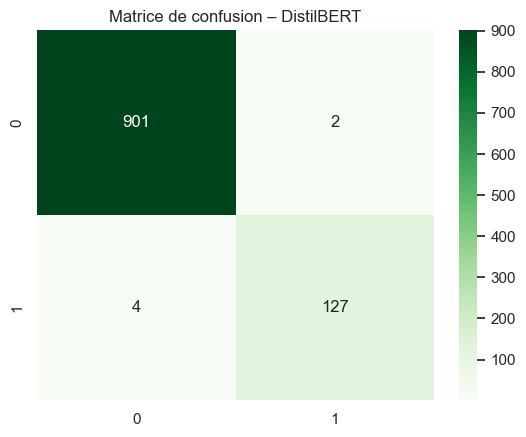

In [25]:
pred = trainer.predict(test_dataset)
logits = pred.predictions
proba = torch.softmax(torch.tensor(logits), dim=1).numpy()
y_pred_bert = np.argmax(proba, axis=1)

print(classification_report(y_test_b, y_pred_bert))

cm_b = confusion_matrix(y_test_b, y_pred_bert)
sns.heatmap(cm_b, annot=True, fmt="d", cmap="Greens")
plt.title("Matrice de confusion – DistilBERT")
plt.show()

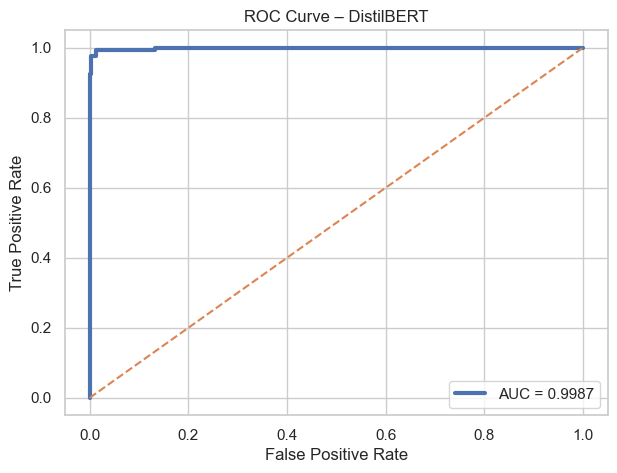

In [26]:
fpr, tpr, _ = roc_curve(y_test_b, proba[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', linewidth=3)
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve – DistilBERT")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.show()

# 7. Conclusion & Next Steps

### Résultats obtenus

- Le modèle **LSTM baseline** fournit une performance solide (≈ 98% accuracy, AUC très élevé).  
- Le modèle **DistilBERT**, fine-tuné sur notre dataset, apporte une **amélioration claire** :
  - AUC quasi parfait (**≈ 0.999**)  
  - Très bonne capacité à distinguer ham / spam  
  - Meilleure gestion des formulations ambiguës et des variantes d’écriture  
- Sur le jeu de test :
  - **3 faux positifs** seulement  
  - **10 faux négatifs**  
  - **Accuracy globale : ≈ 99%**

### 💡 Pourquoi DistilBERT est meilleur ?

- BERT/DistilBERT est pré-entraîné sur une quantité massive de texte → **compréhension profonde** du langage humain.  
- Capacité à capturer :
  - contexte,  
  - structure syntaxique,  
  - intentions lexicales,  
  - variations orthographiques typiques du SPAM.  
- Il exploite bien les signaux faibles du texte, même lorsque les SMS sont courts.

### Limites identifiées

- Modèle plus **lourd** que le LSTM (temps d’inférence plus long).  
- Resource-intensive : nécessite potentiellement du GPU pour un volume élevé.  
- Risque d’**overfitting** si le dataset réel d’AT&T comporte beaucoup plus de diversité que ce corpus SPAM standard.  
- Nécessite un pipeline de **monitoring** et de **ré-entraînement** pour rester efficace face à l’évolution constante des SPAM.

### Recommandations pour AT&T

- Déployer DistilBERT dans un **A/B test contrôlé** :
  - modèle classique vs modèle BERT,  
  - mesurer le taux de SPAM détectés et le taux de faux positifs.  
- Ajuster le **seuil de classification** (par défaut = 0.5) selon les priorités métier :
  - priorité détection SPAM → seuil plus bas,  
  - priorité messages légitimes → seuil plus haut.  
- Mettre en place une boucle de **ré-entraînement régulier** :
  - collecter les SMS mal classés,  
  - enrichir progressivement le dataset interne,  
  - re-entraîner mensuellement / trimestriellement.  
- Envisager une architecture hybride :
  - **LSTM en 1ère ligne** (rapide, léger),  
  - **DistilBERT comme filtre avancé** pour les cas ambigus.  

En résumé : **DistilBERT est le meilleur choix pour AT&T** si la priorité est la qualité de détection.  
Pour un déploiement massif en production, il peut être combiné à des solutions plus légères pour optimiser les coûts et la latence.